# Mount Google Drive

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive", force_remount=True)

# Importing libraries

In [5]:
import glob
import os
import numpy as np
import pandas as pd
from collections import defaultdict
from string import punctuation
import re
import matplotlib.pyplot as plt
%matplotlib inline

import nltk
nltk.download('punkt')
from nltk.corpus import wordnet as wn
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.stem.wordnet import WordNetLemmatizer
from nltk import word_tokenize, pos_tag
nltk.download('averaged_perceptron_tagger') # need for pos_tag

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/arifulalam/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/arifulalam/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/arifulalam/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/arifulalam/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

# Global Variables

If you're in Google Colab, you should run this cell below:

In [4]:
BASE_PATH = "/content/gdrive/MyDrive/MSC research/document clustering/"

If you're in local machine, you should run this cell below:

In [7]:
BASE_PATH = "./"

# Loading Data

In [8]:
def read_documents_20ng(data_path_train):
    docs = []
    labels = []

    a = glob.glob(os.path.join(data_path_train, '*'))
    for aa in a:
        b = glob.glob(os.path.join(aa, '*'))
        for bb in b:
            with open(bb, encoding='latin1') as f:
                docs.append(f.read())
                labels.append(aa.replace(data_path_train, ''))

    return docs, labels

## Training Data

### Data loading

In [9]:
data_path_train = f'{BASE_PATH}data/20news-bydate-train/'

In [10]:
train_docs, train_labels = read_documents_20ng(data_path_train)

In [11]:
print('Training data:', len(train_docs))
print('Number of categories:', len(np.unique(train_labels)))
print('Categories:', np.unique(train_labels))

Training data: 1728
Number of categories: 3
Categories: ['comp.graphics' 'rec.motorcycles' 'talk.politics.guns']


### Finding frequency of each category

In [12]:
len(train_labels)

1728

In [13]:
train_targets, train_frequency = np.unique(train_labels, return_counts=True)
print(train_targets)
print(train_frequency)
print(list(zip(train_targets, train_frequency)))

['comp.graphics' 'rec.motorcycles' 'talk.politics.guns']
[584 598 546]
[('comp.graphics', 584), ('rec.motorcycles', 598), ('talk.politics.guns', 546)]


### Class distribution


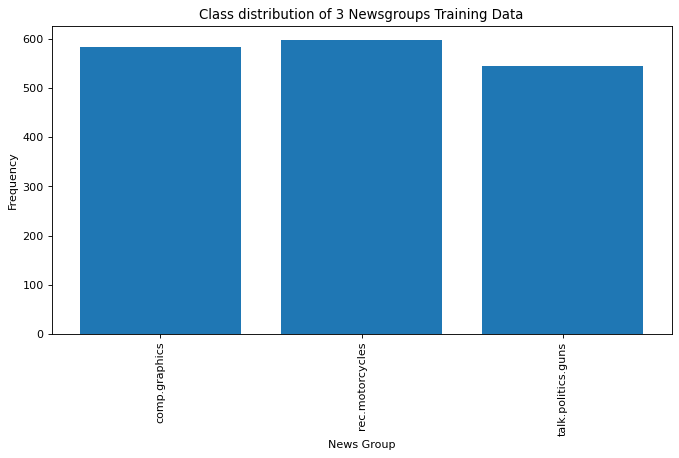

In [14]:
fig=plt.figure(figsize=(10, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.bar(train_targets, train_frequency)
plt.xticks(rotation=90)
plt.title(f'Class distribution of {len(train_targets)} Newsgroups Training Data')
plt.xlabel('News Group')
plt.ylabel('Frequency')
plt.show()

## Testing Data

### Data loading

In [15]:
data_path_test = f'{BASE_PATH}data/20news-bydate-test/'

In [16]:
test_docs, test_labels = read_documents_20ng(data_path_test)

In [17]:
print('Testing data:', len(test_docs))
print('Number of categories:', len(np.unique(test_labels)))
print('Categories:', np.unique(test_labels))

Testing data: 1151
Number of categories: 3
Categories: ['comp.graphics' 'rec.motorcycles' 'talk.politics.guns']


### Finding frequency of each category

In [18]:
test_targets, test_frequency = np.unique(test_labels, return_counts=True)
print(test_targets)
print(test_frequency)
print(list(zip(test_targets, test_frequency)))

['comp.graphics' 'rec.motorcycles' 'talk.politics.guns']
[389 398 364]
[('comp.graphics', 389), ('rec.motorcycles', 398), ('talk.politics.guns', 364)]


### Class distribution


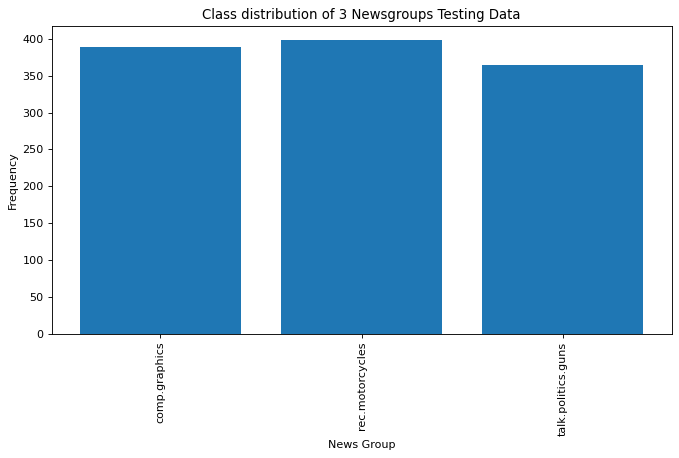

In [19]:
fig=plt.figure(figsize=(10, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.bar(test_targets, test_frequency)
plt.xticks(rotation=90)
plt.title(f'Class distribution of {len(test_targets)} Newsgroups Testing Data')
plt.xlabel('News Group')
plt.ylabel('Frequency')
plt.show()

# Pre-process data

## Creating STOP WORDS

Intial stop words from `sklearn.feature_extraction._stop_words`

In [20]:
from sklearn.feature_extraction._stop_words import ENGLISH_STOP_WORDS # Total 318 words

In [22]:
stopWords=list(ENGLISH_STOP_WORDS)

We can also use stopwords from `ntlk`

In [21]:
# from nltk.corpus import stopwords
# nltk.download('stopwords')
# stopWords=stopwords.words('english') # Total 179 words

Adding some more common stop words throughout all docs which doesn't play no part in classification

In [23]:
stopWords+=['subject','from', 'date', 'reply-to', 'newsgroups', 'message-id', 'lines', 'path', 'organization', 
            'would', 'writes', 'references', 'article', 'sender', 'nntp-posting-host', 'people', 
            'university', 'think', 'xref', 'cantaloupe.srv.cs.cmu.edu', 'could', 'distribution', 'first', 
            'anyone', 'really', 'since', 'believe', 'still', 
            "max>'ax>'ax>'ax>'ax>'ax>'ax>'ax>'ax>'ax>'ax>'ax>'ax>'ax>'ax>'"]

In [24]:
stopWords = set(stopWords)

## Lemmatizer
Lemmatizer minimizes text ambiguity. Example words like bicycle or bicycles are converted to base word bicycle. Basically, it will convert all words having the same meaning but different representation to their base form. It reduces the word density in the given text and helps in preparing the accurate features for training machine. Cleaner the data, the more intelligent and accurate your machine learning model, will be. NLTK Lemmatizer will also saves memory as well as computational cost.

In [25]:
# Initialization
lemmatizer = WordNetLemmatizer()

# Creating a POS tag map
tag_map = defaultdict(lambda : wn.NOUN)
tag_map['J'] = wn.ADJ
tag_map['V'] = wn.VERB
tag_map['R'] = wn.ADV

def convertWordIntoLemmatizeWord(words):
  return [lemmatizer.lemmatize(word, tag_map[tag[0]]) for word, tag in pos_tag(words)]

## Defining a pre-process function

* Remove numbers. ✅
* Convert word into lowercase word. ✅
* Remove all stop words. ✅
* Remove all punctuations. ✅
* Some white spaces may be added to the list of words, due to the translate function & nature of our documents. Remove them as well. ✅
* Remove just-numeric strings. ✅
* Lemmatize. ✅
* Remove words with only 2 characters or less. [Low frequency] ✅
* Remove words with more than 12 characters. [High frequency] ✅


In [26]:
def preprocess(words):
  #First, remove numbers
  words = [re.sub(r"\d+", "", word) for word in words]
  #Normalize the cases of our words
  words = [word.lower() for word in words]
  #Remove all punctuations
  table = str.maketrans('', '', punctuation)
  words = [word.translate(table) for word in words]
  #Some white spaces may be added to the list of words, due to the translate function & nature of our documents. We've to remove them.
  words = [word for word in words if word]
  #Remove just-numeric strings
  words = [word for word in words if not word.isdigit()]
  #Lemmatize
  words = convertWordIntoLemmatizeWord(words)
  #Remove all stop words
  words = [word for word in words if word not in stopWords]
  #Remove words with less than 3 characters and more than 12 characters
  words = [word for word in words if len(word) > 2 and len(word) <= 12]
  return words

## Creating pre-process documents function

In [27]:
def preprocess_documents(docs):
  preprocessed_docs = []
  for doc in docs:
    words = word_tokenize(doc)
    words = preprocess(words)
    preprocessed_docs.append(" ".join(words))
  return preprocessed_docs

## Preprocess training data

Raw data:

In [28]:
train_docs[0]

"From: jjd1@cbnewsg.cb.att.com (james.j.dutton)\nSubject: Re: bikes with big dogs\nOrganization: AT&T\nDistribution: na\nLines: 20\n\nIn article <1993Apr14.234835.1@cua.edu> 84wendel@cua.edu writes:\n>Has anyone ever heard of a rider giving a big dog such as a great dane a ride \n>on the back of his bike.  My dog would love it if I could ever make it work.\n>\tThanks\n>\t\t\t84wendel@cua.edu\n \n If a large Malmute counts then yes someone has heard(and seen) such\nan irresponsible childish stunt. The dog needed assistance straightening\nout once on board. The owner would lift the front legs of dog and throw\nthem over the driver/pilots shoulders. Said dog would get shit eating\ngrin on its face and away they'd go. The dogs ass was firmly planted\non the seat.\n \n My dog and this dog actively seek each other out at camping party's.\nThey hate each other. I think it's something personal.\n \n================================================================================\n Steatopygias'

Pre-processing documents:

In [29]:
preprocessed_train_docs = preprocess_documents(train_docs)

Pre-processed data:

In [30]:
preprocessed_train_docs[0]

'jjd jamesjdutton bike big dog line apr cuaedu wendel cuaedu write heard rider big dog great dane ride bike dog love make work thanks wendel cuaedu large malmute count yes hear childish stunt dog need assistance straighten board owner lift leg dog throw driverpilots shoulder say dog shit eat grin face away dog firmly plant seat dog dog actively seek camp party hate personal steatopygia doh hottentot ama dod'

Preparing DataFrame:

In [31]:
training_df = pd.DataFrame({'data': preprocessed_train_docs, 'target': train_labels})
training_df.head()

,data,target
0,jjd jamesjdutton bike big dog line apr cuaedu ...,rec.motorcycles
1,remmons robert emmons mail order articleid iat...,rec.motorcycles
2,nrmendel nathaniel mendell opinion want help a...,rec.motorcycles
3,ramarren applecom godfrey digiorgi der whassa ...,rec.motorcycles
4,jburnside llmitedu jamie burnside bike want ad...,rec.motorcycles


Saving as CSV:

In [32]:
training_df.to_csv(f'{BASE_PATH}training_df.csv', index=False, encoding='utf-8')

## Preprocess testing data

Raw data:

In [33]:
test_docs[0]

'From: chrispi@microsoft.com (Chris Pirih)\nSubject: Re: First Bike??\nOrganization: Microsoft Corporation\nLines: 39\n\nIn rec.motorcycles James Leo Belliveau <jbc9+@andrew.cmu.edu> writes:\n;    I am a serious motorcycle enthusiast without a motorcycle, and to\n;put it bluntly, it sucks.  I really would like some advice on what would\n;be a good starter bike for me.  I do know one thing however, I need to\n;make my first bike a good one, because buying a second any time soon is\n;out of the question.  I am specifically interested in racing bikes, (CBR\n;600 F2, GSX-R 750).  I know that this may sound kind of crazy\n;considering that I\'ve never had a bike before, but I am responsible, a\n;fast learner, and in love.  \n\nResponsible and in love?  I believe that\'s a contradiction\nin terms.\n\nUnless you\'re really brave (read: "reckless") a 500cc sport\nbike will go way faster than you dare for at least your first\nyear of riding.  Getting more than that really is overkill,\nas you\'

Pre-processing documents:

In [34]:
preprocessed_test_docs = preprocess_documents(test_docs)

Pre-processed data:

In [35]:
preprocessed_test_docs[0]

'chrispi microsoftcom chris pirih bike microsoft corporation line james leo belliveau jbc andrewcmuedu write motorcycle enthusiast motorcycle bluntly suck like advice good starter bike know thing need make bike good buy second time soon question specifically interested race bike cbr gsxr know sound kind crazy consider bike responsible fast learner love responsible love term unless brave read reckless sport bike way faster dare year rid overkill want use following bike buy repair cheaply easy novice manage plenty high performance kawasaki honda interceptor suzuki gse mph time throttle way sooner ready small probably wish power pretty quickly unless tzr rgv say certain kill immediately gsxr plenty start rid bike just fine say waste money waste perfectly good plastic drop thing learn balance stop throttle half open spend extra buck chris'

Preparing DataFrame:

In [36]:
testing_df = pd.DataFrame({'data': preprocessed_test_docs, 'target': test_labels})
testing_df.head()

,data,target
0,chrispi microsoftcom chris pirih bike microsof...,rec.motorcycles
1,mbeaving bnrca beav opinion mean bmerh replyto...,rec.motorcycles
2,arturo informixcom arturo vega bonding caged c...,rec.motorcycles
3,mrr pocwruedu mark rabne insure cbrf case west...,rec.motorcycles
4,wayneorwig wayne orwig battery storage charge ...,rec.motorcycles


Saving as CSV:

In [37]:
testing_df.to_csv(f'{BASE_PATH}testing_df.csv', index=False, encoding='utf-8')

# Bag of WORDS: TF-IDF Vectorizer

In [38]:
from sklearn.feature_extraction.text import TfidfVectorizer

Reading TRAINING from CSV:

In [39]:
training_df = pd.read_csv(f'{BASE_PATH}training_df.csv') 

Reading TESTING from CSV:

In [40]:
testing_df = pd.read_csv(f'{BASE_PATH}testing_df.csv') 

We next convert our corpus into tf-idf vectors.

In [41]:
# tfidfV = TfidfVectorizer() 
tfidfV = TfidfVectorizer(min_df=2, max_df=0.5) # We remove terms with very low document frequency (many of them are numbers or misspells).

`fit_transform` learns the vocab and one-hot encodes 

In [42]:
X_train_tfidfV = tfidfV.fit_transform(training_df.data)

In [43]:
print(X_train_tfidfV.shape)

(1728, 10114)


`transform` uses the same vocab and one-hot encodes

In [44]:
X_test_tfidfV = tfidfV.transform(testing_df.data)

In [45]:
print(X_test_tfidfV.shape)

(1151, 10114)


In [46]:
X_train_tfidfV_df = pd.DataFrame(X_train_tfidfV.todense(), columns=tfidfV.get_feature_names_out())
X_train_tfidfV_df.head()

,aaah,aaffff,aarghhhh,aaron,abad,abandon,abate,abc,abd,abel,...,zipgun,znextctscom,zog,zone,zoom,zoomins,zxa,zyeh,zyxel,zzr
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
